### Import libraries

### nog te doen:
Normaliseren van alle variabelen
Outlier detectie
Alles afronden op 3 getallen achter de komma
2 hoofdstukken maken, met en zonder add featuers
Na iedere prep head er tussen zetten
data import laten staan en verder hernoemen!!
Per functie doel er in zetten
verzamelen wat je aan kolomen verwijderd en motiveren -> kopieren naar verslag

In [99]:
# libraries
import gpxpy
import gpxpy.gpx
import os
import sys
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


### data import

In [100]:
csv_path = os.path.join('C:/Users/michel.marien_icarew/Documents/GitHub/Machine-learning/docs/', 'Garmin_activity_description.csv')

drop_cols = ['Activiteittype', 'Favoriet', 'CalorieÃ«n','Decompressie','Training Stress ScoreÂ®', 'Gem. vermogen', 'Max. vermogen',
             'Beste rondetijd', 'Aantal ronden','Minimum hoogte', 'Maximum hoogte','Normalized PowerÂ® (NPÂ®)',
             'Gem. staplengte','Gemiddelde verticale ratio', 'Gem. verticale oscillatie' ,'Training effect aeroob',
             'Beste tempo', 'Verstreken tijd', 'Gem. grondcontacttijd', 'Tijd','Gem. GAP','Gem. loopcadans', 
            'Max. loopcadans',]

def import_garmin_summ_csv(csv_path):    

    with open(csv_path, 'r') as csv_file:
        garmin_activities_csv = pd.read_csv(csv_file,
                                        sep=';',
                                        encoding='utf-8')
        
    return garmin_activities_csv

# Create groupings of track distances
def categorize_distance(distance):
    if distance < 8:                # tracks shorter than 8 km
        return '8'
    elif distance < 12:             # tracks shorter than 12 km
        return '12'
    elif distance < 20:             # tracks shorter than 20 km
        return '20'
    else:
        return '100'               # failsafe group


def prep_garmin_summ (csv_path,cols_to_drop):

    garmin_activities_csv = import_garmin_summ_csv(csv_path)

    # Filter rows where Afstand > 1
    garmin_activities_csv = garmin_activities_csv[garmin_activities_csv['Afstand'] > 1]

    # Reset the index if needed
    garmin_activities_csv = garmin_activities_csv.reset_index(drop=True) 

    garmin_activities_csv['Afstand'] = garmin_activities_csv['Afstand'].round(0) 

    garmin_activities_csv['track_lengths'] = garmin_activities_csv['Afstand'].apply(categorize_distance)

    garmin_activities_prep = garmin_activities_csv.loc[garmin_activities_csv['Activiteittype'] == 'Hardlopen']
    
    # Remove 'hardlopen' (case insensitive) from Titel column
    garmin_activities_prep.loc[:, 'Titel'] = garmin_activities_prep['Titel'].str.replace('hardlopen', '', case=False).str.strip()

    # Remove any potential double spaces that might have been created
    garmin_activities_prep.loc[:, 'Titel'] = garmin_activities_prep['Titel'].str.replace('  ', ' ')
# verkennende ronde
    garmin_activities_prep = garmin_activities_prep[garmin_activities_prep.groupby('Titel')['Titel'].transform('count') > 1]
    
    garmin_activities_prep = garmin_activities_prep.drop(cols_to_drop,axis=1)

    garmin_activities_prep.replace("--", np.nan, inplace=True)

    garmin_activities_prep = garmin_activities_prep[garmin_activities_prep['Afstand'] >= 1]

    # Drop rows with any missing values
    garmin_activities_prep = garmin_activities_prep.dropna(subset=['Titel'])
    garmin_activities_prep = garmin_activities_prep[garmin_activities_prep['Titel'].notna() & (garmin_activities_prep['Titel'] != '')]

    # Reset the index (optional)
    garmin_activities_prep = garmin_activities_prep.reset_index(drop=True)

    # Convert numeric text columns to float
    numeric_columns = ['Gem. HS', 'Max. HS',  'Totale stijging', 'Totale daling']
    
    for col in numeric_columns:
        garmin_activities_prep[col] = garmin_activities_prep[col].apply(lambda x: float(str(x).replace(',', '.').strip()))

    return garmin_activities_prep

garmin_activities_prep = prep_garmin_summ(csv_path, drop_cols)

garmin_activities_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Datum            198 non-null    object 
 1   Titel            198 non-null    object 
 2   Afstand          198 non-null    float64
 3   Gem. HS          198 non-null    float64
 4   Max. HS          198 non-null    float64
 5   Gemiddeld tempo  198 non-null    object 
 6   Totale stijging  184 non-null    float64
 7   Totale daling    192 non-null    float64
 8   Tijd bewogen     198 non-null    object 
 9   track_lengths    198 non-null    object 
dtypes: float64(5), object(5)
memory usage: 15.6+ KB


In [101]:
garmin_activities_prep['Datum'] = pd.to_datetime(garmin_activities_prep['Datum'])


garmin_activities_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            198 non-null    datetime64[ns]
 1   Titel            198 non-null    object        
 2   Afstand          198 non-null    float64       
 3   Gem. HS          198 non-null    float64       
 4   Max. HS          198 non-null    float64       
 5   Gemiddeld tempo  198 non-null    object        
 6   Totale stijging  184 non-null    float64       
 7   Totale daling    192 non-null    float64       
 8   Tijd bewogen     198 non-null    object        
 9   track_lengths    198 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 15.6+ KB


In [102]:
# Remove 'hardlopen' (case insensitive) from Titel column
garmin_activities_prep['Titel'] = garmin_activities_prep['Titel'].str.replace('hardlopen', '', case=False).str.strip()

# Remove any potential double spaces that might have been created
garmin_activities_prep['Titel'] = garmin_activities_prep['Titel'].str.replace('  ', ' ')

import string

# Remove punctuation and convert to lowercase
garmin_activities_prep.columns = (
    garmin_activities_prep.columns
    .str.lower()  # Convert to lowercase
    .str.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    .str.replace(' ', '_')  # Replace spaces with underscores
)

garmin_activities_prep.head()

,datum,titel,afstand,gem_hs,max_hs,gemiddeld_tempo,totale_stijging,totale_daling,tijd_bewogen,tracklengths
0,2024-12-20 15:38:00,Waalre,12.0,172.0,183.0,05:22,13.0,25.0,01:01:59,20
1,2024-12-12 13:54:00,Waalre,11.0,178.0,186.0,05:28,15.0,23.0,01:02:40,12
2,2024-12-03 15:56:00,Loon op Zand,10.0,173.0,183.0,05:41,31.0,34.0,00:57:12,12
3,2024-11-26 15:56:00,Loon op Zand,10.0,176.0,188.0,05:50,35.0,36.0,01:00:02,12
4,2024-11-19 16:06:00,Loon op Zand,10.0,182.0,191.0,05:58,33.0,38.0,00:58:51,12


### data exploration

In [103]:
garmin_activities_prep['gemiddeld_tempo'] = pd.to_timedelta('00:' + garmin_activities_prep['gemiddeld_tempo'])

    # Extract total seconds from timedelta objects
garmin_activities_prep['gemiddeld_tempo'] = garmin_activities_prep['gemiddeld_tempo'].dt.total_seconds()

garmin_activities_prep['gemiddeld_tempo_km/h'] = 3600 / garmin_activities_prep['gemiddeld_tempo']

# Convert 'tijd_bewogen' to total seconds
garmin_activities_prep['tijd_bewogen'] = pd.to_timedelta(garmin_activities_prep['tijd_bewogen']).dt.total_seconds()


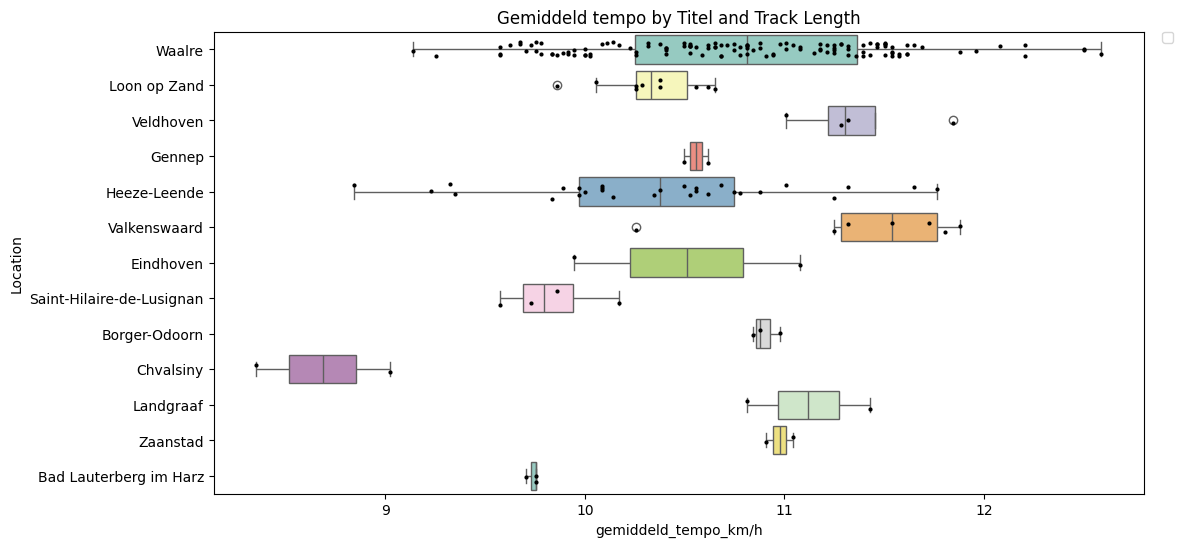

In [104]:

def plot_boxplot(df):
    # Create the box plot with 'Titel_Track' on the y-axis and 'Gemiddeld tempo' on the x-axis
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    sns.boxplot(y='titel', x='gemiddeld_tempo_km/h', data=df, hue='titel', palette="Set3", dodge=False)
    sns.stripplot(y='titel', x='gemiddeld_tempo_km/h', data=df, color='black', size=3, jitter=0.2, dodge=False)  # Add individual data points

    plt.title("Gemiddeld tempo by Titel and Track Length")
    plt.ylabel("Location")
    plt.xlabel('gemiddeld_tempo_km/h')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 
    plt.show()

# Call the function with your preprocessed dataframe
plot_boxplot(garmin_activities_prep)

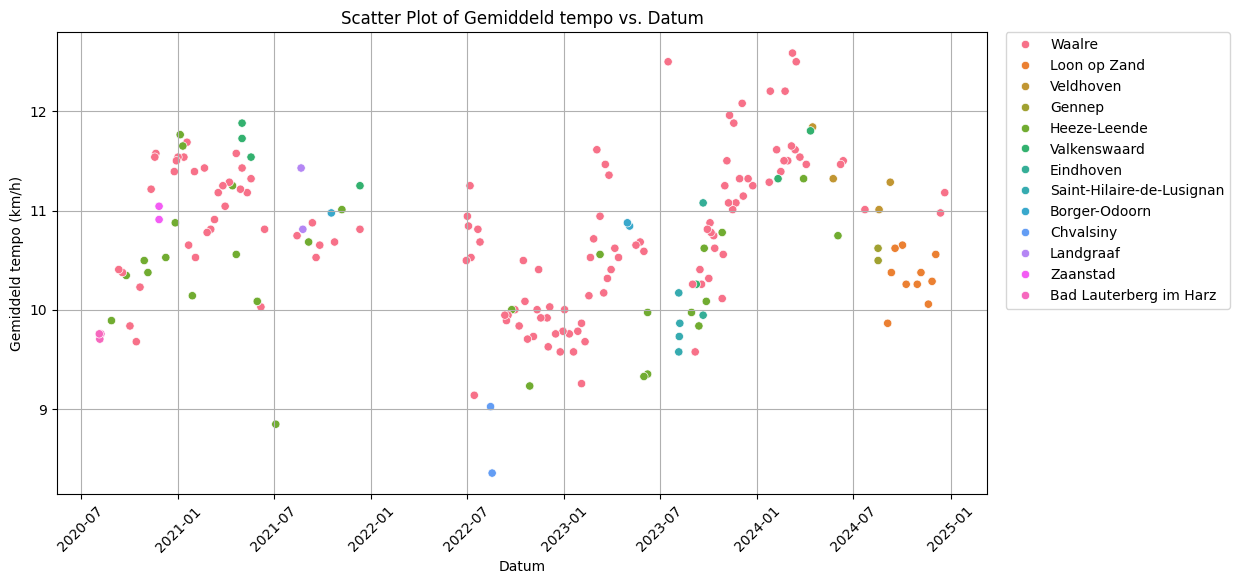

In [105]:

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='datum', y='gemiddeld_tempo_km/h', hue='titel', data=garmin_activities_prep)

# Set plot labels and title
plt.grid(True)
plt.xlabel('Datum')
plt.ylabel('Gemiddeld tempo (km/h)')
plt.title('Scatter Plot of Gemiddeld tempo vs. Datum')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [106]:
### data splitsen

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preparation
def prepare_data(df):
    # Drop rows with missing values in target variable
    df = df.dropna(subset=['gemiddeld_tempo_km/h'])
    
    # Create distance bins for stratification
    df['distance_bin'] = pd.qcut(df['afstand'], q=5, labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
    
    return df

# 2. Split Data
def split_data(df):
    # First split: 70% train, 30% remaining
    X = df[['afstand']]
    y = df['gemiddeld_tempo_km/h']
    strat = df['distance_bin']
    
    X_train, X_temp, y_train, y_temp, strat_train, strat_temp = train_test_split(
        X, y, strat, train_size=0.7, random_state=42, stratify=strat
    )
    
    # Second split: Split remaining 30% into half (15% each for validation and test)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=strat_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# 3. Model Training and Evaluation
def train_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test):
    results = []
    degrees = [1, 2, 3, 4, 5]
    
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        X_test_poly = poly.transform(X_test)
        
        # Initialize and train model
        model = LinearRegression()
        
        # Perform 5-fold cross validation on training set
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_poly, y_train, cv=kf, scoring='r2')
        
        # Fit model on full training set
        model.fit(X_train_poly, y_train)
        
        # Calculate metrics
        train_r2 = model.score(X_train_poly, y_train)
        val_r2 = model.score(X_val_poly, y_val)
        test_r2 = model.score(X_test_poly, y_test)
        
        results.append({
            'Degree': degree,
            'CV Mean R2': cv_scores.mean(),
            'CV Std R2': cv_scores.std(),
            'Train R2': train_r2,
            'Validation R2': val_r2,
            'Test R2': test_r2
        })
        
    return pd.DataFrame(results)

# 4. Plotting Function
def plot_regression_results(X_train, X_test, y_train, y_test, degrees):
    plt.figure(figsize=(12, 8))
    
    # Plot training data
    plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
    plt.scatter(X_test, y_test, color='green', alpha=0.5, label='Test Data')
    
    for degree in degrees:
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train)
        model = LinearRegression()
        model.fit(X_poly, y_train)
        
        # Generate predictions for plotting
        x_range = np.linspace(X_train.min(), X_train.max(), 100)
        X_range_poly = poly.transform(x_range.reshape(-1, 1))
        y_pred = model.predict(X_range_poly)
        
        plt.plot(x_range, y_pred, label=f'Degree {degree}')
    
    plt.xlabel('afstand')
    plt.ylabel('gemiddeld_tempo_km/h')
    plt.title('Polynomial Regression Models with Train/Test Split')
    plt.legend()
    plt.grid(True)
    
    return plt


Model Performance Results:
 Degree  CV Mean R2  CV Std R2  Train R2  Validation R2   Test R2
      1   -0.028885   0.031505  0.012826       0.048104 -0.005672
      2   -0.036241   0.036340  0.013172       0.050342 -0.013214
      3   -0.050335   0.098717  0.036076       0.047098 -0.056349
      4    0.021685   0.096142  0.103191       0.258946 -0.156028
      5    0.008351   0.138334  0.125655       0.165894 -0.139947


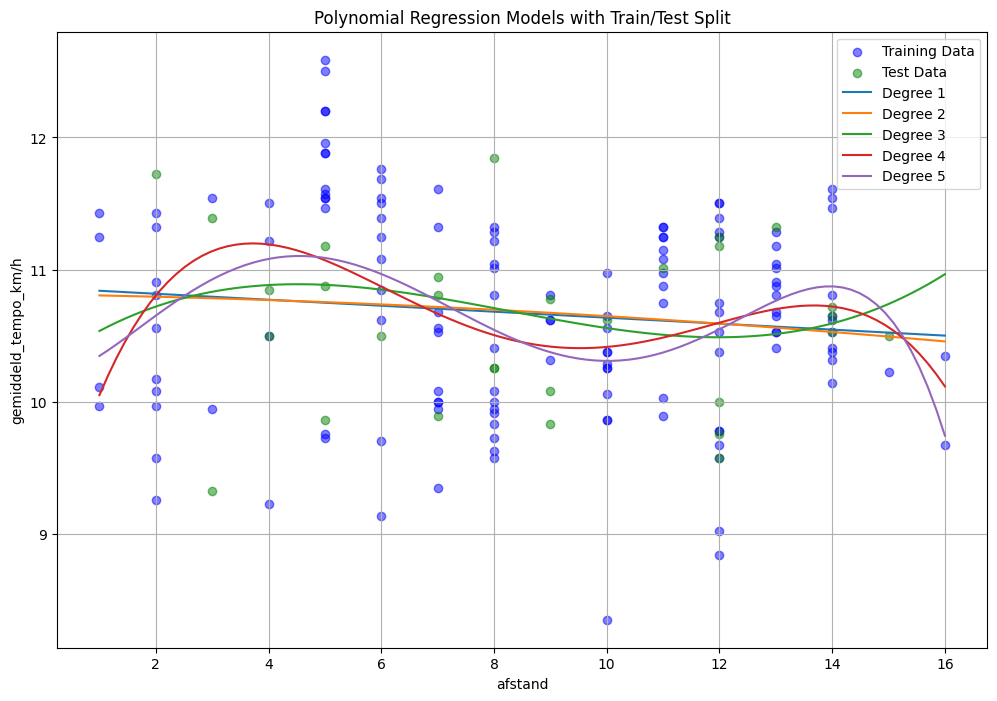

In [107]:
# Main execution
def analyze_running_performance(df):
    # Prepare data
    df_prepared = prepare_data(df)
    
    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_prepared)
    
    # Train and evaluate models
    results = train_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Create plot
    plt = plot_regression_results(X_train, X_test, y_train, y_test, degrees=[1, 2, 3, 4, 5])
    
    return results, plt

# Execute analysis
results, plt = analyze_running_performance(garmin_activities_prep)
print("\nModel Performance Results:")
print(results.to_string(index=False))
plt.show()

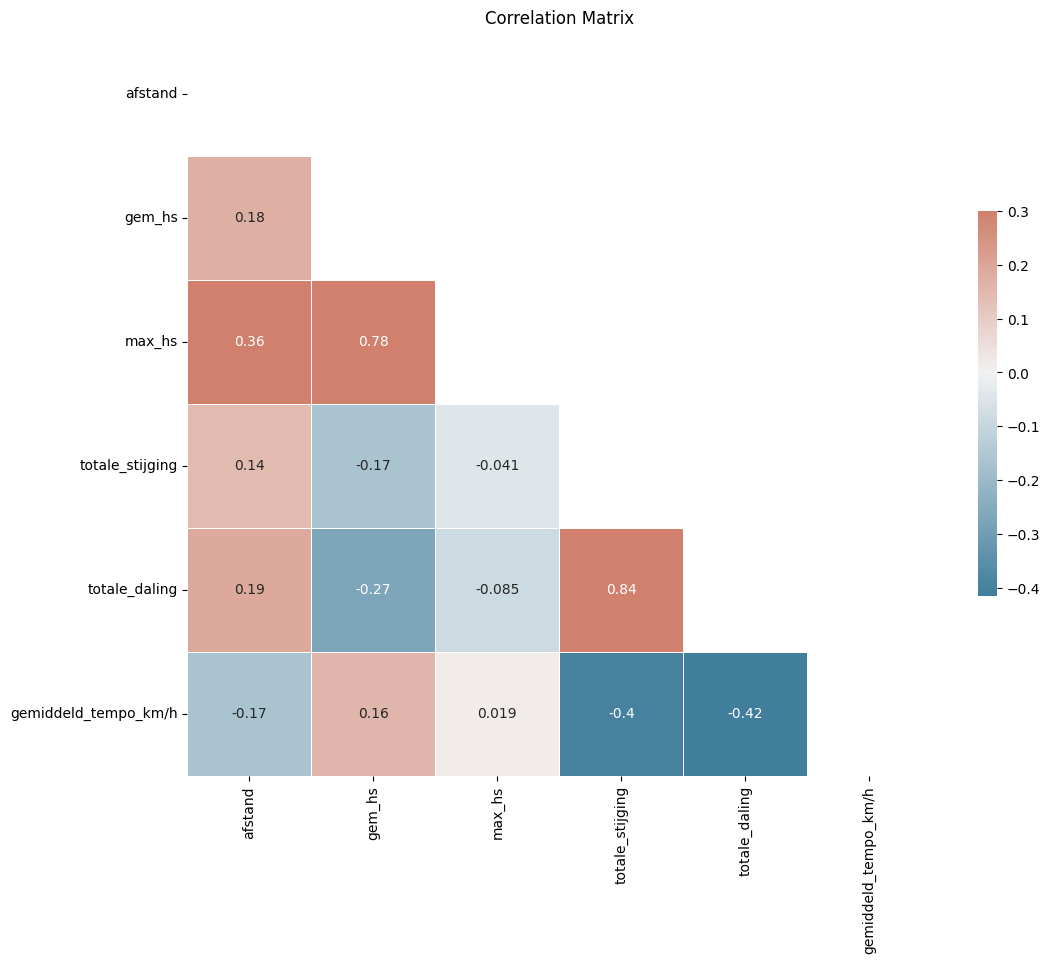

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

drop_cols = ['titel', 'datum', 'gemiddeld_tempo', 'tracklengths', 'tijd_bewogen']

# Calculate correlation matrix
corr_matrix = garmin_activities_prep.drop(drop_cols,axis=1).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a custom colormap for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap with correlation coefficients
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [109]:
drop_cols = ['titel', 'datum', 'gemiddeld_tempo', 'tracklengths', 'tijd_bewogen']

# Calculate correlation matrix
garmin_activities_prep_uni_regr = garmin_activities_prep.drop(drop_cols,axis=1)

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def run_multivariate_analysis(df, target_column):
    """
    Run complete multivariate regression analysis with simplified approach.
    """
    # 1. Data Preparation
    # Drop rows with missing values and select numeric columns
    df = df.dropna()
    X = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # 2. Split Data
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # 3. Train Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
##################
    #degree = 2  # You can change this to your desired degree
    # Create polynomial features
    #poly_features = PolynomialFeatures(degree=degree)
    #X_train_poly = poly_features.fit_transform(X_train) 

    # Initialize and train the model using polynomial features
    #model = LinearRegression()
    #model.fit(X_train_poly, y_train) 

     #X_new_poly = poly_features.transform(X_new) 
     #predictions = model.predict(X_new_poly)

    # 4. Make Predictions
    #y_train_pred = model.predict(poly_features.transform(X_train))
    #y_val_pred = model.predict(poly_features.transform(X_val))
    #y_test_pred = model.predict(poly_features.transform(X_test))
##################################
    # 4. Make Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # 5. Calculate Metrics
    results = {
        'Train R2': r2_score(y_train, y_train_pred),
        'Validation R2': r2_score(y_val, y_val_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
    
    # 6. Feature Importance
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    # 7. Visualizations
    plt.figure(figsize=(15, 10))
    
    # Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train')
    plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validation')
    plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.legend()
    
    # Residual Plot
    plt.subplot(2, 2, 2)
    plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.5, label='Train')
    plt.scatter(y_val_pred, y_val - y_val_pred, alpha=0.5, label='Validation')
    plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, label='Test')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.legend()
    
    # Feature Importance
    plt.subplot(2, 2, 3)
    sns.barplot(data=importance.head(10), x='Coefficient', y='Feature')
    plt.title('Top 10 Feature Importance')
    
    # Correlation Heatmap
    plt.subplot(2, 2, 4)
    sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'scaler': scaler,
        'results': results,
        'importance': importance
    }


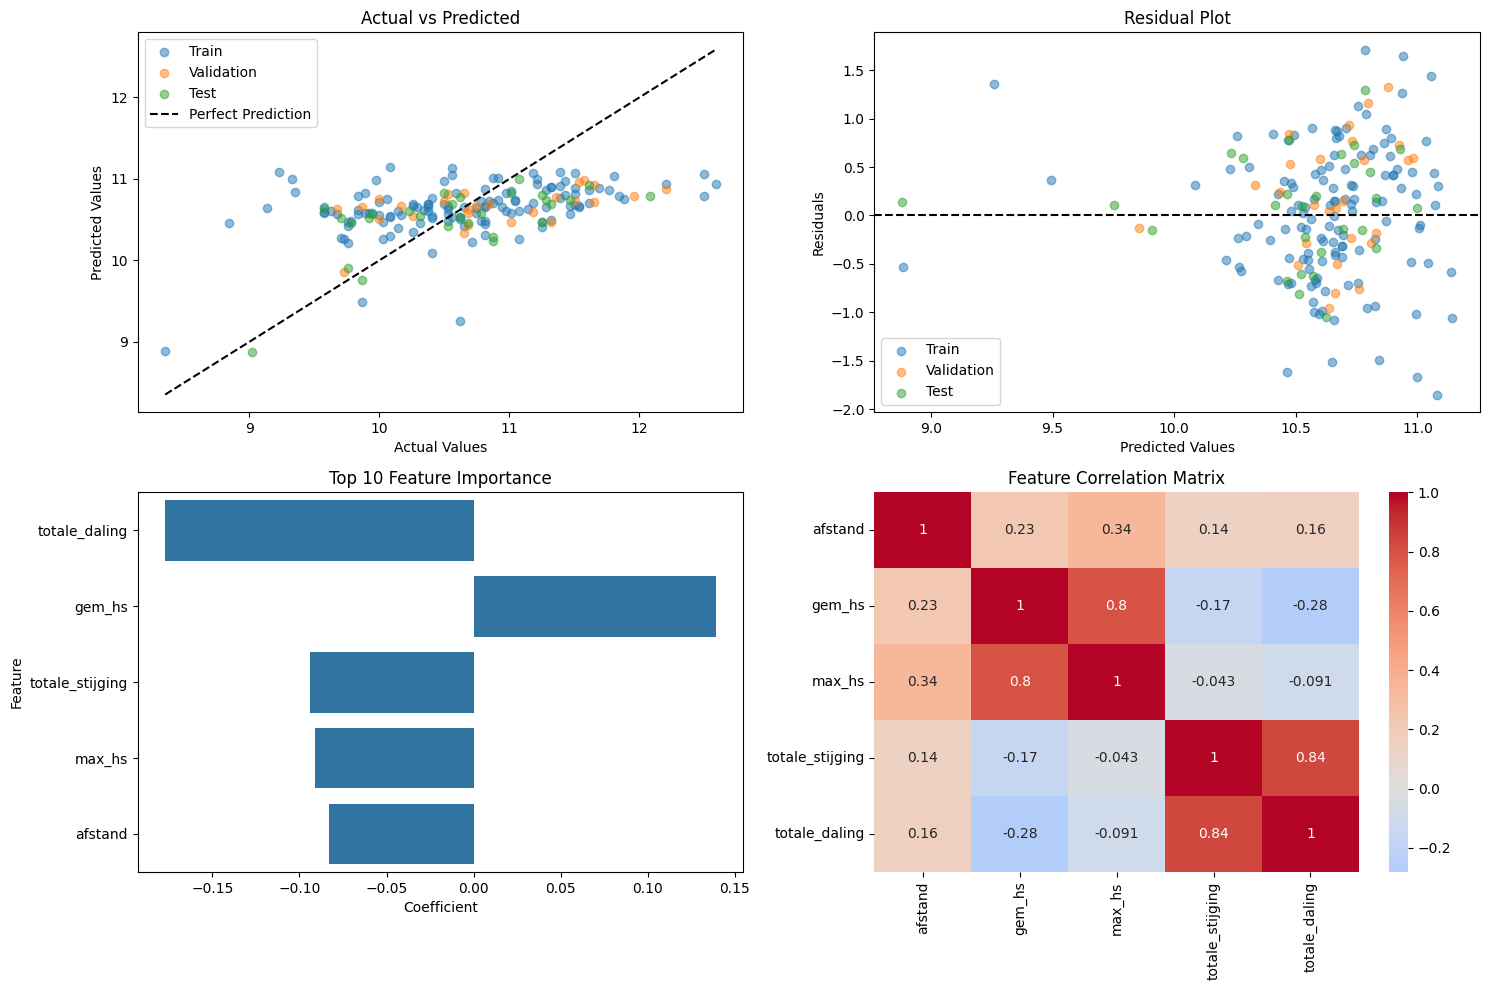


Model Performance:
Train R2: 0.1687
Validation R2: 0.1650
Test R2: 0.3863
Train RMSE: 0.6911
Validation RMSE: 0.6254
Test RMSE: 0.5497

Top 5 Most Important Features:
           Feature  Coefficient
4    totale_daling    -0.177127
1           gem_hs     0.139056
3  totale_stijging    -0.093719
2           max_hs    -0.090942
0          afstand    -0.083324


In [111]:
# With your own data
df = garmin_activities_prep_uni_regr
results = run_multivariate_analysis(df, target_column='gemiddeld_tempo_km/h')
    
# Print results
print("\nModel Performance:")
for metric, value in results['results'].items():
    print(f"{metric}: {value:.4f}")

print("\nTop 5 Most Important Features:")
print(results['importance'].head())

#### import additional features

In [112]:
## import additional features

add_features_path = os.path.join('C:/Users/michel.marien_icarew/Documents/GitHub/Machine-learning/docs/', 'Additional_features.csv')

def import_garmin_summ_csv(add_features_path):    

    with open(add_features_path , 'r') as csv_file:
        addfeatures_csv = pd.read_csv(csv_file,
                                        sep=';',
                                        encoding='utf-8')
        
    addfeatures_csv =addfeatures_csv.rename(columns={'ï»¿datum': 'datum'})

    num_cols = ['afstand', 'addfeat_asphalt', 'addfeat_forest', 'addfeat_dunes','addfeat_temp','addfeat_windsp','addfeat_humid']   

    for col in num_cols:
        addfeatures_csv[col] = pd.to_numeric(addfeatures_csv[col])
    
        
    return addfeatures_csv

garmin_activities_addfeatures = import_garmin_summ_csv(add_features_path)
garmin_activities_addfeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datum            216 non-null    object 
 1   plaats           216 non-null    object 
 2   afstand          216 non-null    float64
 3   addfeat_asphalt  216 non-null    float64
 4   addfeat_forest   216 non-null    float64
 5   addfeat_dunes    216 non-null    float64
 6   addfeat_temp     216 non-null    float64
 7   addfeat_sky      216 non-null    object 
 8   addfeat_windsp   216 non-null    int64  
 9   addfeat_winddir  216 non-null    object 
 10  addfeat_humid    216 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 18.7+ KB


In [113]:
# First ensure both datetime columns are in the same format
garmin_activities_prep['datum'] = pd.to_datetime(garmin_activities_prep['datum'])
garmin_activities_addfeatures['datum'] = pd.to_datetime(garmin_activities_addfeatures['datum'])

# Perform left join
garmin_activities_addfeat = pd.merge(
    garmin_activities_prep,
    garmin_activities_addfeatures,
    on=['datum'],  # Replace 'second_column' with your actual second column
    how='left'
)

garmin_activities_addfeat

,datum,titel,afstand_x,gem_hs,max_hs,gemiddeld_tempo,totale_stijging,totale_daling,tijd_bewogen,tracklengths,...,plaats,afstand_y,addfeat_asphalt,addfeat_forest,addfeat_dunes,addfeat_temp,addfeat_sky,addfeat_windsp,addfeat_winddir,addfeat_humid
0,2024-12-20 15:38:00,Waalre,12.0,172.0,183.0,322.0,13.0,25.0,3719.0,20,...,Waalre,11.54,1.00,0.00,0.00,6.1,bewolkt,20,zzw,0.87
1,2024-12-12 13:54:00,Waalre,11.0,178.0,186.0,328.0,15.0,23.0,3760.0,12,...,Waalre,11.46,1.00,0.00,0.00,2.8,mist,2,nnw,1.00
2,2024-12-03 15:56:00,Loon op Zand,10.0,173.0,183.0,341.0,31.0,34.0,3432.0,12,...,Loon op Zand,10.08,0.64,0.12,0.24,6.7,bewolkt,11,nw,0.74
3,2024-11-26 15:56:00,Loon op Zand,10.0,176.0,188.0,350.0,35.0,36.0,3602.0,12,...,Loon op Zand,10.31,0.64,0.12,0.24,9.4,bewolkt,11,zzw,0.84
4,2024-11-19 16:06:00,Loon op Zand,10.0,182.0,191.0,358.0,33.0,38.0,3531.0,12,...,Loon op Zand,9.88,0.64,0.12,0.24,3.9,bewolkt,11,nnw,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2020-09-10 12:35:00,Waalre,13.0,180.0,191.0,346.0,27.0,11.0,4329.0,20,...,Waalre,12.53,0.62,0.38,0.00,18.9,bewolkt,11,nno,0.46
194,2020-08-27 16:47:00,Heeze-Leende,11.0,179.0,192.0,364.0,14.0,4.0,4099.0,12,...,Heeze-Leende,11.26,0.64,0.36,0.00,21.1,bewolkt,15,zzo,0.53
195,2020-08-07 17:15:00,Bad Lauterberg im Harz,5.0,165.0,182.0,369.0,89.0,44.0,1865.0,8,...,Bad Lauterberg im Harz,5.05,0.90,0.10,0.00,31.1,zon,11,o,0.38
196,2020-08-05 17:19:00,Bad Lauterberg im Harz,6.0,157.0,174.0,371.0,80.0,67.0,2052.0,8,...,Bad Lauterberg im Harz,5.53,0.90,0.10,0.00,27.8,zon,9,zw,0.28


In [114]:
# Step 1: Sort by 'datum'
garmin_activities_merged = garmin_activities_addfeat.sort_values(by='datum').reset_index(drop=True)

# Step 2: Calculate time difference with the previous row
time_diff = garmin_activities_merged['datum'].diff()

# Step 3: Define columns for aggregation
sum_columns = ['afstand_y', 'totale_stijging', 'totale_daling', 'tijd_bewogen']
avg_columns = ['gem_hs', 'gemiddeld_tempo', 'addfeat_asphalt', 'addfeat_forest',
               'addfeat_dunes', 'addfeat_temp', 'addfeat_windsp', 'addfeat_humid']
max_columns = ['max_hs']
keep_first_row_entry_columns = ['datum', 'addfeat_winddir', 'tracklengths']

# Function to merge consecutive rows where time difference < 1 hour
def merge_rows(df):
    merged_rows = []
    temp_group = df.iloc[0].copy()  # Start with the first row
    
    for i in range(1, len(df)):
        current_row = df.iloc[i]
        
        # Check if time difference is less than 1 hour
        if (current_row['datum'] - temp_group['datum']) < pd.Timedelta(hours=2.5):
            # Merge values
            for col in sum_columns:
                temp_group[col] += current_row[col]
            
            for col in avg_columns:
                temp_group[col] = (temp_group[col] + current_row[col]) / 2  # Update average
            
            for col in max_columns:
                temp_group[col] = max(temp_group[col], current_row[col])
            
            # Keep the first row's entry for specific columns (no change needed)
        
        else:
            # Store merged result and start a new group
            merged_rows.append(temp_group)
            temp_group = current_row.copy()
    
    # Append the last processed row
    merged_rows.append(temp_group)
    
    return pd.DataFrame(merged_rows)

# Step 4: Keep repeating until all necessary rows are merged
previous_length = len(garmin_activities_merged) + 1  # Set a different initial length
while previous_length > len(garmin_activities_merged):  # Run until no more merging occurs
    previous_length = len(garmin_activities_merged)
    garmin_activities_merged = merge_rows(garmin_activities_merged)

# Final cleaned DataFrame
garmin_activities_cleaned = garmin_activities_merged.reset_index(drop=True)
garmin_activities_cleaned

,datum,titel,afstand_x,gem_hs,max_hs,gemiddeld_tempo,totale_stijging,totale_daling,tijd_bewogen,tracklengths,...,plaats,afstand_y,addfeat_asphalt,addfeat_forest,addfeat_dunes,addfeat_temp,addfeat_sky,addfeat_windsp,addfeat_winddir,addfeat_humid
0,2020-08-04 17:04:00,Bad Lauterberg im Harz,6.0,159.0,176.0,369.0,86.0,82.0,2085.0,8,...,Bad Lauterberg im Harz,5.66,0.90,0.10,0.00,22.2,zon,15.0,w,0.38
1,2020-08-05 17:19:00,Bad Lauterberg im Harz,6.0,157.0,174.0,371.0,80.0,67.0,2052.0,8,...,Bad Lauterberg im Harz,5.53,0.90,0.10,0.00,27.8,zon,9.0,zw,0.28
2,2020-08-07 17:15:00,Bad Lauterberg im Harz,5.0,165.0,182.0,369.0,89.0,44.0,1865.0,8,...,Bad Lauterberg im Harz,5.05,0.90,0.10,0.00,31.1,zon,11.0,o,0.38
3,2020-08-27 16:47:00,Heeze-Leende,11.0,179.0,192.0,364.0,14.0,4.0,4099.0,12,...,Heeze-Leende,11.26,0.64,0.36,0.00,21.1,bewolkt,15.0,zzo,0.53
4,2020-09-10 12:35:00,Waalre,13.0,180.0,191.0,346.0,27.0,11.0,4329.0,20,...,Waalre,12.53,0.62,0.38,0.00,18.9,bewolkt,11.0,nno,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2024-11-19 16:06:00,Loon op Zand,10.0,182.0,191.0,358.0,33.0,38.0,3531.0,12,...,Loon op Zand,9.88,0.64,0.12,0.24,3.9,bewolkt,11.0,nnw,0.92
180,2024-11-26 15:56:00,Loon op Zand,10.0,176.0,188.0,350.0,35.0,36.0,3602.0,12,...,Loon op Zand,10.31,0.64,0.12,0.24,9.4,bewolkt,11.0,zzw,0.84
181,2024-12-03 15:56:00,Loon op Zand,10.0,173.0,183.0,341.0,31.0,34.0,3432.0,12,...,Loon op Zand,10.08,0.64,0.12,0.24,6.7,bewolkt,11.0,nw,0.74
182,2024-12-12 13:54:00,Waalre,11.0,178.0,186.0,328.0,15.0,23.0,3760.0,12,...,Waalre,11.46,1.00,0.00,0.00,2.8,mist,2.0,nnw,1.00


In [115]:
#gem_hs en max_hs zijn dependent en niet te beinvloeden

### gem_hs en max_hs zijn dependent en niet te beinvloeden, ook haal ik daling weg -> veel stijgen betekent ook veel dalen

In [116]:
drop_cols = ['totale_daling', 'max_hs','gem_hs','titel', 'datum', 'afstand_x','plaats', 'gemiddeld_tempo', 'tracklengths', 'tijd_bewogen', 'addfeat_sky','addfeat_winddir']

# Calculate correlation matrix
garmin_activities_addfeat_regr = garmin_activities_cleaned.drop(drop_cols,axis=1)
garmin_activities_addfeat_regr

,totale_stijging,gemiddeld_tempo_km/h,afstand_y,addfeat_asphalt,addfeat_forest,addfeat_dunes,addfeat_temp,addfeat_windsp,addfeat_humid
0,86.0,9.756098,5.66,0.90,0.10,0.00,22.2,15.0,0.38
1,80.0,9.703504,5.53,0.90,0.10,0.00,27.8,9.0,0.28
2,89.0,9.756098,5.05,0.90,0.10,0.00,31.1,11.0,0.38
3,14.0,9.890110,11.26,0.64,0.36,0.00,21.1,15.0,0.53
4,27.0,10.404624,12.53,0.62,0.38,0.00,18.9,11.0,0.46
...,...,...,...,...,...,...,...,...,...
179,33.0,10.055866,9.88,0.64,0.12,0.24,3.9,11.0,0.92
180,35.0,10.285714,10.31,0.64,0.12,0.24,9.4,11.0,0.84
181,31.0,10.557185,10.08,0.64,0.12,0.24,6.7,11.0,0.74
182,15.0,10.975610,11.46,1.00,0.00,0.00,2.8,2.0,1.00


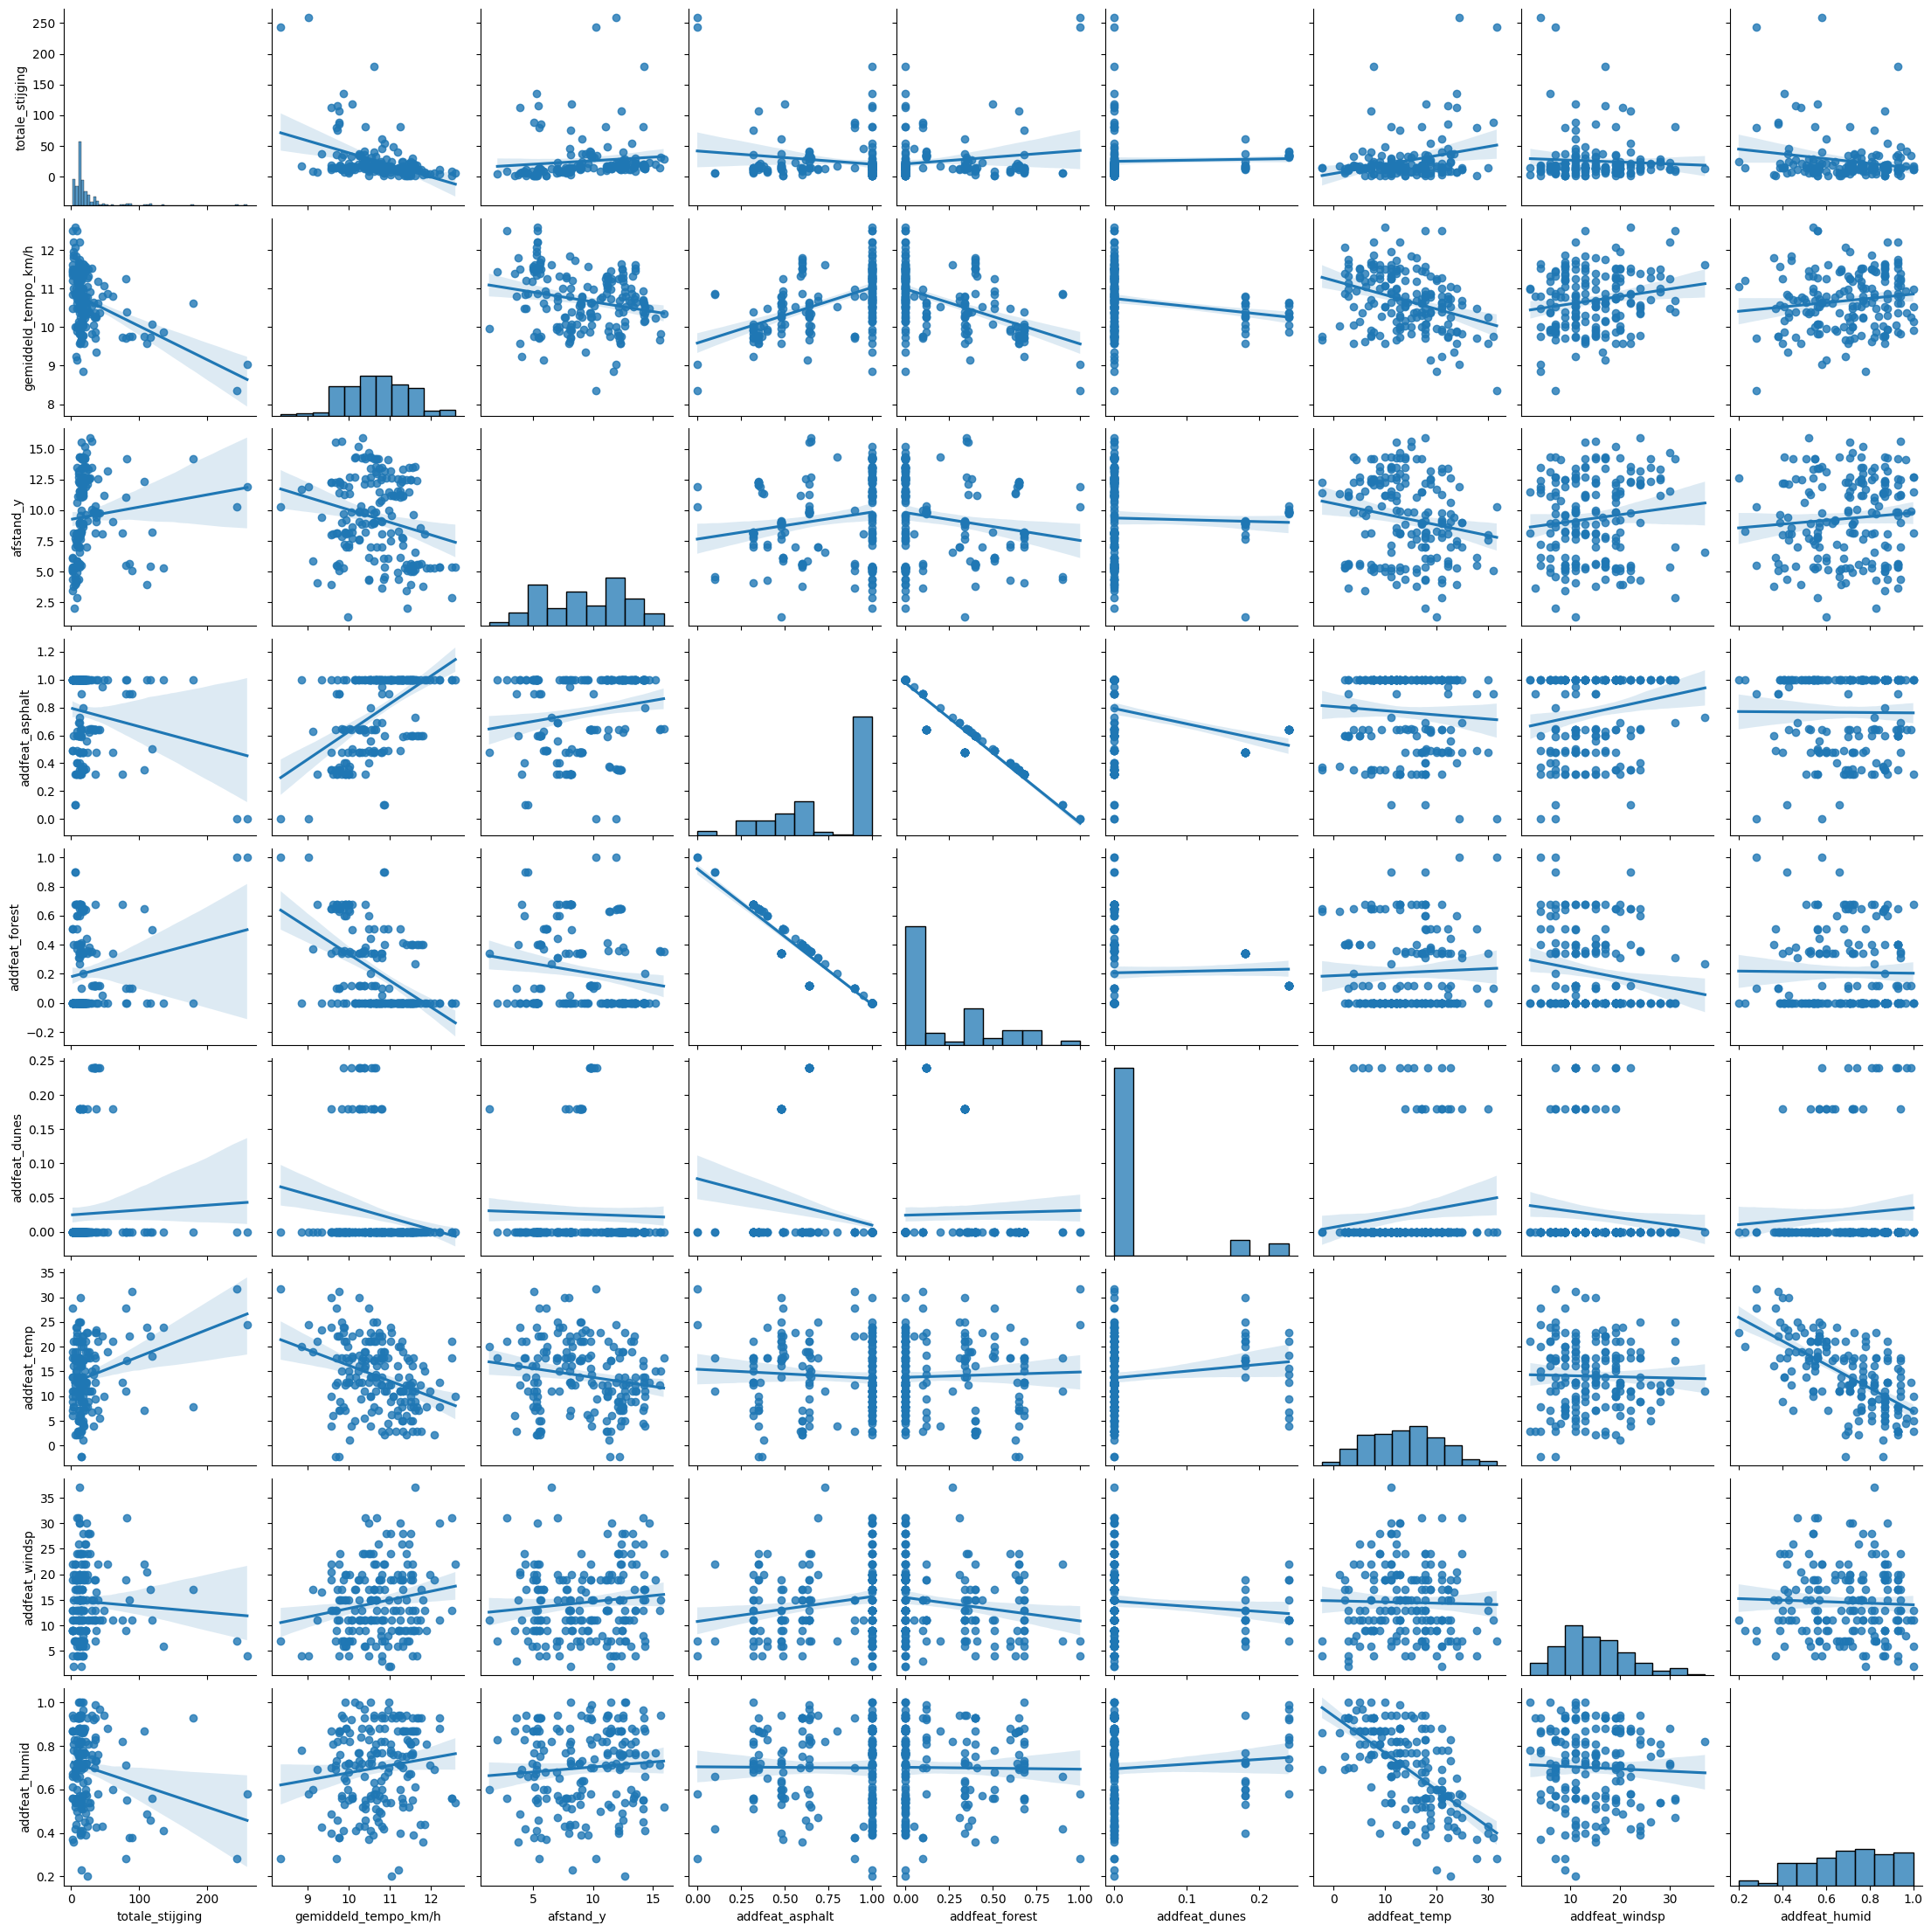

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats  # Import stats from scipy

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

# Select numerical columns for correlation
#numerical_cols = ['Afstand', 'Gem. HS', 'Max. HS', 'Gemiddeld tempo', 'Totale stijging',
#                  'Totale daling', 'Gem. vermogen', 'Max. vermogen', 'Gemiddeld tempo_km/h']
#
# Calculate correlation matrix
#corr_matrix = garmin_activities_prep[numerical_cols].corr()

# Create the pair plot with correlation coefficients
g = sns.pairplot(garmin_activities_addfeat_regr, kind="reg")
#g.map_lower(corrfunc)  # Apply corrfunc to the lower triangle
plt.show()

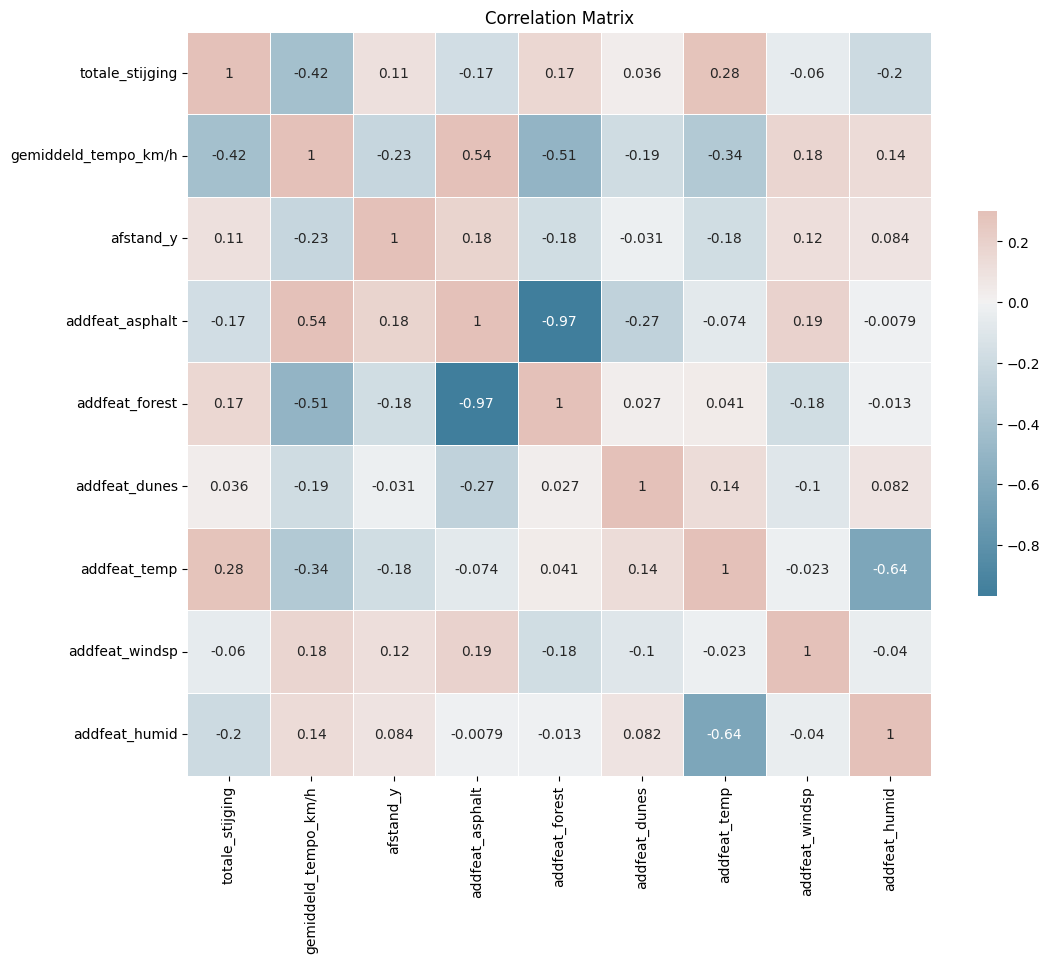

In [118]:
# Select numerical columns for correlation, including 'Titel_Numeric'
drop_cols = ['tracklengths', 'gemiddeld_tempo']

# Calculate correlation matrix
corr_matrix = garmin_activities_addfeat_regr.corr()

# Create a mask for the upper triangle
#mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a custom colormap for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap with correlation coefficients
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(corr_matrix, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlation Matrix")
plt.show()

In [119]:
# Select numerical columns for correlation, including 'Titel_Numeric'
drop_cols = ['tracklengths', 'gemiddeld_tempo', 'gem_hs', 'max_hs']

corr_matrix = garmin_activities_addfeat_regr.corr()

print(corr_matrix['gemiddeld_tempo_km/h'])


totale_stijging        -0.415283
gemiddeld_tempo_km/h    1.000000
afstand_y              -0.227515
addfeat_asphalt         0.537518
addfeat_forest         -0.511006
addfeat_dunes          -0.185062
addfeat_temp           -0.341928
addfeat_windsp          0.180914
addfeat_humid           0.137870
Name: gemiddeld_tempo_km/h, dtype: float64


In [120]:
import statsmodels

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming you have your feature matrix in a DataFrame called 'X'
# and your target variable in a Series called 'y'

# Select numerical columns for correlation, including 'Titel_Numeric'
drop_cols = ['tracklengths', 'gemiddeld_tempo', 'gem_hs', 'max_hs']

garmin_activities_cleaned.vif = garmin_activities_addfeat_regr

# Add a constant column to the feature matrix (required for VIF calculation)
garmin_activities_cleaned.vif['intercept'] = 1

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = garmin_activities_cleaned.vif.columns
vif["VIF"] = [variance_inflation_factor(garmin_activities_cleaned.vif.values, i) for i in range(garmin_activities_cleaned.vif.shape[1])]

# Display the VIF values
print(vif)

ModuleNotFoundError: No module named 'statsmodels'

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def stratified_resample(X, y, n_bins=10, random_state=None):
    """
    Perform stratified resampling for regression problems by binning the target variable.
    
    Parameters:
    -----------
    X : array-like
        Features
    y : array-like
        Target variable (continuous)
    n_bins : int
        Number of bins to use for stratification
    random_state : int or None
        Random state for reproducibility
    
    Returns:
    --------
    X_resampled, y_resampled : tuple
        Resampled features and target
    """
    # Create bins for stratification
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbd.fit_transform(y.values.reshape(-1, 1)).ravel()
    
    # Combine features and target
    combined_data = np.column_stack([X, y])
    
    # Perform stratified resampling
    unique_bins = np.unique(y_binned)
    resampled_data = []
    
    for bin_val in unique_bins:
        bin_indices = np.where(y_binned == bin_val)[0]
        bin_data = combined_data[bin_indices]
        
        # Resample with replacement within each bin
        resampled_bin = resample(bin_data, 
                               n_samples=len(bin_indices),
                               random_state=random_state)
        resampled_data.append(resampled_bin)
    
    # Combine resampled data from all bins
    resampled_combined = np.vstack(resampled_data)
    np.random.shuffle(resampled_combined)
    
    # Split back into features and target
    X_resampled = resampled_combined[:, :-1]
    y_resampled = resampled_combined[:, -1]
    
    return X_resampled, y_resampled

def run_multivariate_analysis(df, target_column, degrees=[1], k=5, train_size=0.6, val_size=0.2, test_size=0.2, n_bins=10):
    """
    Run complete multivariate regression analysis with polynomial feature expansion and stratified k-fold cross-validation.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing features and target
    target_column : str
        Name of the target column in df
    degrees : list, optional
        List of polynomial degrees to test (default: [1])
    k : int, optional
        Number of folds for cross-validation (default: 5)
    train_size : float, optional
        Proportion of data for training (default: 0.6)
    val_size : float, optional
        Proportion of data for validation (default: 0.2)
    test_size : float, optional
        Proportion of data for testing (default: 0.2)
    n_bins : int, optional
        Number of bins for stratification (default: 10)
    
    Returns:
    --------
    dict
        Dictionary containing results table and scaler object
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame")
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame")
    if not np.isclose(train_size + val_size + test_size, 1.0):
        raise ValueError("train_size + val_size + test_size must sum to 1.0")

    # Data Preparation
    df = df.dropna()
    X = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    y = df[target_column]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # Create bins for stratified split
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbd.fit_transform(y.values.reshape(-1, 1)).ravel()
    
    # Stratified data splitting
    X_train, X_temp, y_train, y_temp, y_bin_train, y_bin_temp = train_test_split(
        X_scaled, y, y_binned, 
        test_size=(1 - train_size), 
        random_state=42,
        stratify=y_binned
    )
    
    val_test_ratio = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test, y_bin_val, y_bin_test = train_test_split(
        X_temp, y_temp, y_bin_temp,
        test_size=val_test_ratio,
        random_state=42,
        stratify=y_bin_temp
    )
    
    results_list = []
    
    for degree in degrees:
        try:
            # Create polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)
            X_val_poly = poly.transform(X_val)
            X_test_poly = poly.transform(X_test)
            
            # Train Model with Stratified Cross-Validation
            model = LinearRegression()
            stratified_cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=422)
            scores = cross_val_score(
                model, 
                X_train_poly, 
                y_train, 
                cv=stratified_cv.split(X_train_poly, y_bin_train),
                scoring='r2'
            )
            
            # Stratified Bootstrap Sampling
            X_train_boot, y_train_boot = stratified_resample(
                X_train_poly, 
                y_train,
                n_bins=n_bins,
                random_state=42
            )
            
            # Fit model on bootstrapped data
            model.fit(X_train_boot, y_train_boot)
            
            # Make predictions
            y_train_pred = model.predict(X_train_poly)
            y_val_pred = model.predict(X_val_poly)
            y_test_pred = model.predict(X_test_poly)
            
            # Calculate metrics
            results_list.append({
                'Degree': degree,
                'Train R2': r2_score(y_train, y_train_pred),
                'Validation R2': r2_score(y_val, y_val_pred),
                'Test R2': r2_score(y_test, y_test_pred),
                'Cross-Validation R2 Mean': np.mean(scores),
                'Cross-Validation R2 Std': np.std(scores),
                'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
                'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
            })
            
            # Visualization
            plt.figure(figsize=(12, 5))
            
            # Actual vs Predicted Plot
            plt.subplot(1, 2, 1)
            #plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train')
            #plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validation')
            plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test')
            plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Actual vs Predicted (Degree {degree})')
            plt.legend()
            
            # Residual Plot
            plt.subplot(1, 2, 2)
            #plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.5, label='Train')
            #plt.scatter(y_val_pred, y_val - y_val_pred, alpha=0.5, label='Validation')
            plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, label='Test')
            plt.axhline(y=0, color='k', linestyle='--')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.title(f'Residual Plot (Degree {degree})')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing polynomial degree {degree}: {str(e)}")
            continue
    
    results_df = pd.DataFrame(results_list)
    
    return {
        'results_table': results_df,
        'scaler': scaler
    }

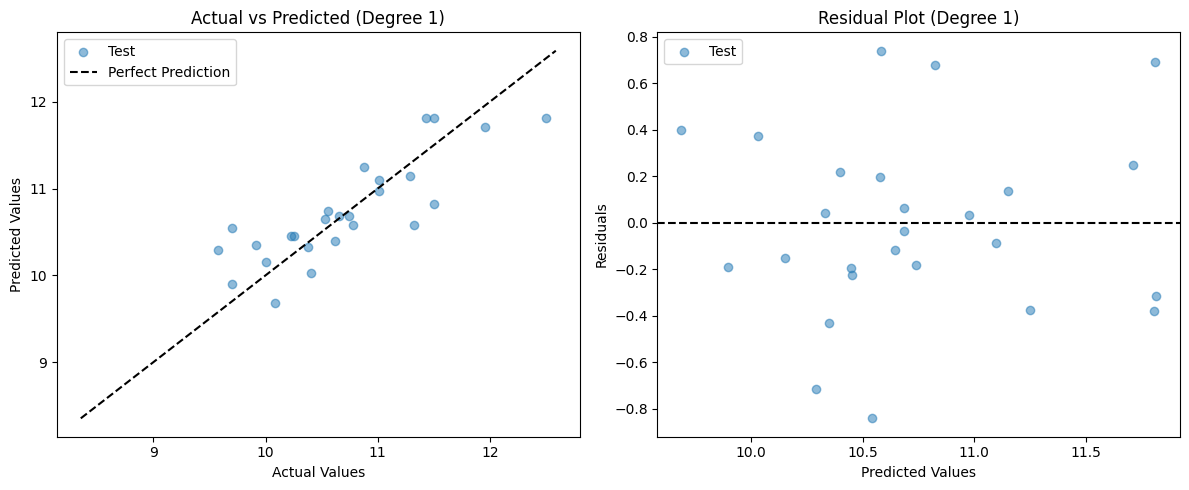

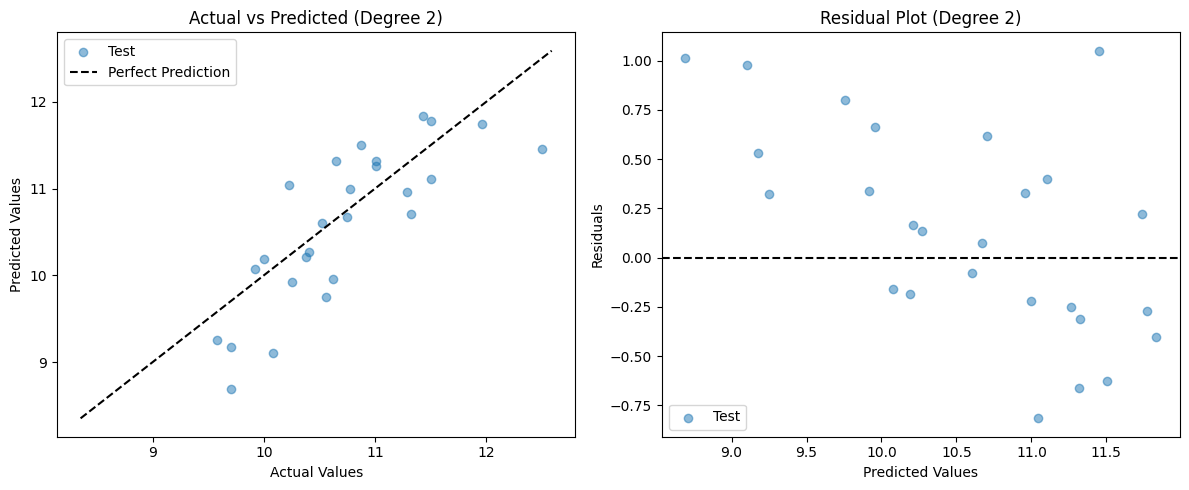

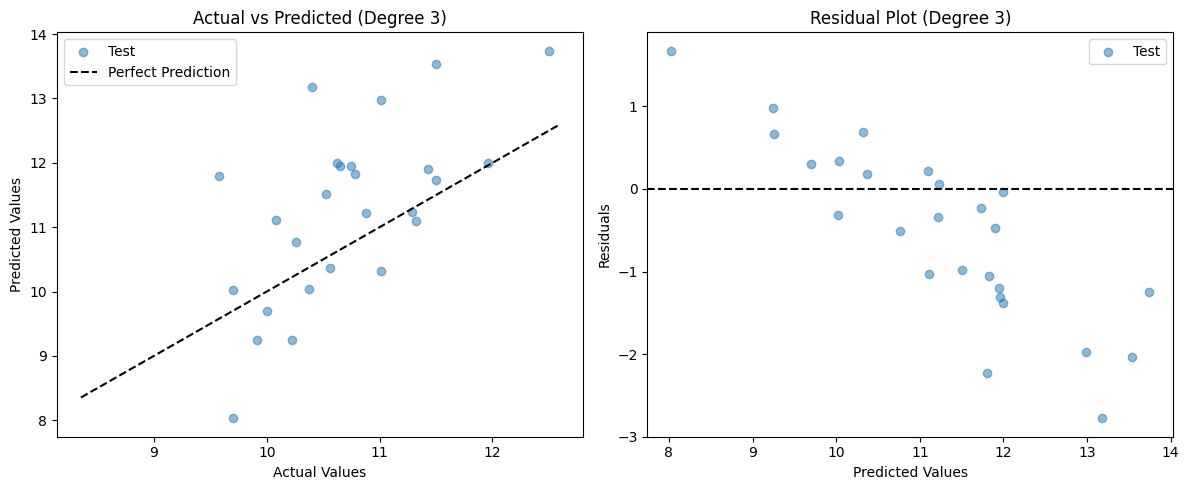


Model Performance for Different Polynomial Degrees:
 Degree  Train R2  Validation R2   Test R2  Cross-Validation R2 Mean  Cross-Validation R2 Std  Train RMSE  Validation RMSE  Test RMSE
      1  0.574345       0.458147  0.696588                  0.447913                 0.191494    0.491956         0.575690   0.389584
      2  0.605209     -11.413779  0.429130                 -1.076022                 4.122080    0.473785         2.755498   0.534384
      3 -2.066661     -48.677614 -1.779141              -2669.827485              6658.668371    1.320475         5.512244   1.179071


In [129]:
df = garmin_activities_addfeat_regr
degrees_to_test = [1, 2, 3]
results = run_multivariate_analysis(
    df, 
    target_column='gemiddeld_tempo_km/h', 
    degrees=degrees_to_test, 
    k=10,
    n_bins = 15, 
    train_size=0.7, 
    val_size=0.15, 
    test_size=0.15
)
print("\nModel Performance for Different Polynomial Degrees:")
print(results['results_table'].to_string(index=False))

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

def run_multivariate_analysis_debug(df, target_column, degrees=[1], train_size=0.7, val_size=0.15, test_size=0.15):
    """Debug version of multivariate analysis"""
    
    # 1. Initial data checks
    print("\nInitial Data Checks:")
    print(f"DataFrame shape: {df.shape}")
    print(f"\nTarget variable '{target_column}' statistics:")
    print(df[target_column].describe())
    
    # Check for inf/nan
    print("\nInfinite values in data:")
    print(df.isin([np.inf, -np.inf]).sum())
    print("\nNaN values in data:")
    print(df.isna().sum())
    
    # 2. Data Preparation
    df = df.dropna()
    X = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    y = df[target_column]
    
    print("\nFeature names:")
    print(X.columns.tolist())
    
    # 3. Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("\nScaled feature statistics:")
    print(pd.DataFrame(X_scaled, columns=X.columns).describe())
    
    # 4. Train/Test Split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=(1-train_size), random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    print("\nData split sizes:")
    print(f"Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")
    
    results_list = []
    
    for degree in degrees:
        print(f"\nProcessing polynomial degree {degree}")
        
        # 5. Polynomial Features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        X_test_poly = poly.transform(X_test)
        
        print(f"Polynomial feature matrix shape: {X_train_poly.shape}")
        print("Polynomial feature statistics:")
        print(f"Min: {X_train_poly.min()}, Max: {X_train_poly.max()}")
        print(f"Mean: {X_train_poly.mean()}, Std: {X_train_poly.std()}")
        
        # 6. Model Fitting
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # 7. Predictions
        y_train_pred = model.predict(X_train_poly)
        y_val_pred = model.predict(X_val_poly)
        y_test_pred = model.predict(X_test_poly)
        
        print("\nPrediction statistics:")
        print("Train predictions:", np.percentile(y_train_pred, [0, 25, 50, 75, 100]))
        print("Test predictions:", np.percentile(y_test_pred, [0, 25, 50, 75, 100]))
        print("Actual test values:", np.percentile(y_test, [0, 25, 50, 75, 100]))
        
        # 8. Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        print(f"\nR² scores for degree {degree}:")
        print(f"Train R²: {train_r2:.6f}")
        print(f"Val R²: {val_r2:.6f}")
        print(f"Test R²: {test_r2:.6f}")
        
        results_list.append({
            'Degree': degree,
            'Train R2': train_r2,
            'Validation R2': val_r2,
            'Test R2': test_r2,
            'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
        })
    
    return pd.DataFrame(results_list)

In [124]:
results_df = run_multivariate_analysis_debug(
    df=garmin_activities_addfeat_regr,
    target_column='gemiddeld_tempo_km/h',
    degrees=[1, 2, 3]
)


Initial Data Checks:
DataFrame shape: (184, 9)

Target variable 'gemiddeld_tempo_km/h' statistics:
count    184.000000
mean      10.692266
std        0.749578
min        8.352668
25%       10.084034
50%       10.682493
75%       11.285266
max       12.587413
Name: gemiddeld_tempo_km/h, dtype: float64

Infinite values in data:
totale_stijging         0
gemiddeld_tempo_km/h    0
afstand_y               0
addfeat_asphalt         0
addfeat_forest          0
addfeat_dunes           0
addfeat_temp            0
addfeat_windsp          0
addfeat_humid           0
dtype: int64

NaN values in data:
totale_stijging         12
gemiddeld_tempo_km/h     0
afstand_y                0
addfeat_asphalt          0
addfeat_forest           0
addfeat_dunes            0
addfeat_temp             0
addfeat_windsp           0
addfeat_humid            0
dtype: int64

Feature names:
['totale_stijging', 'afstand_y', 'addfeat_asphalt', 'addfeat_forest', 'addfeat_dunes', 'addfeat_temp', 'addfeat_windsp', 'addfeat_h

In [125]:
print("Target variable statistics:")
print(df['gemiddeld_tempo_km/h'].describe())

print("\nFeature statistics:")
print(df.drop('gemiddeld_tempo_km/h', axis=1).describe())

Target variable statistics:
count    184.000000
mean      10.692266
std        0.749578
min        8.352668
25%       10.084034
50%       10.682493
75%       11.285266
max       12.587413
Name: gemiddeld_tempo_km/h, dtype: float64

Feature statistics:
       totale_stijging   afstand_y  addfeat_asphalt  addfeat_forest  \
count       172.000000  184.000000       184.000000      184.000000   
mean         25.389535    9.324293         0.764891        0.209402   
std          35.835957    3.387878         0.279024        0.268552   
min           2.000000    1.320000         0.000000        0.000000   
25%          11.000000    6.065000         0.490000        0.000000   
50%          15.000000    9.305000         1.000000        0.000000   
75%          23.250000   12.262500         1.000000        0.400000   
max         259.000000   15.900000         1.000000        1.000000   

       addfeat_dunes  addfeat_temp  addfeat_windsp  addfeat_humid  
count     184.000000    184.000000      

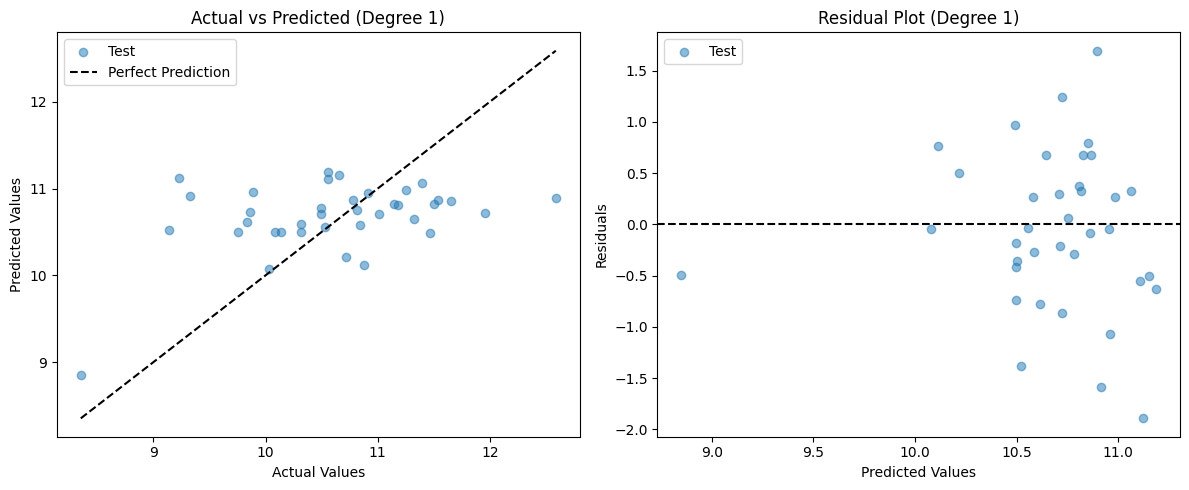

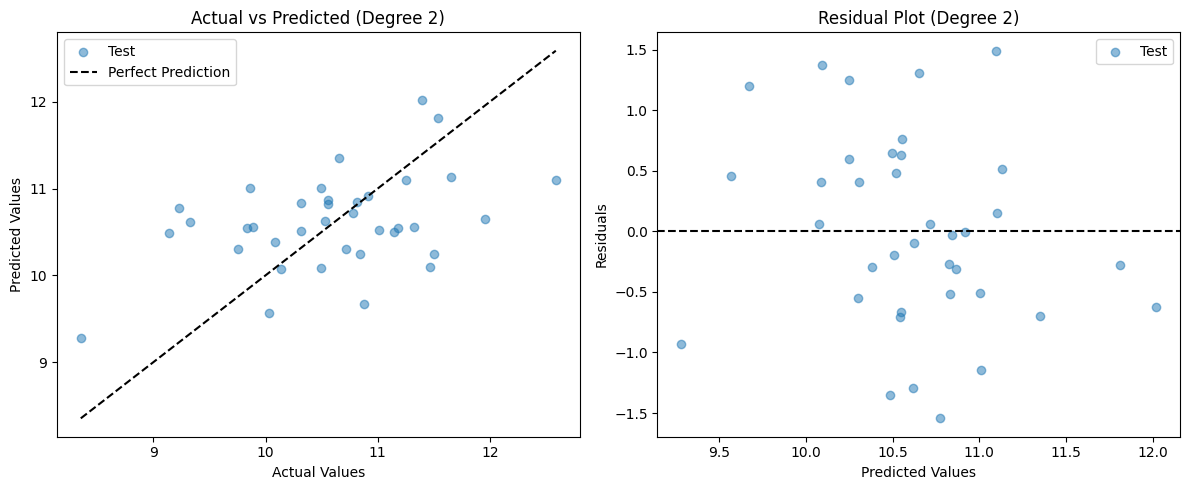

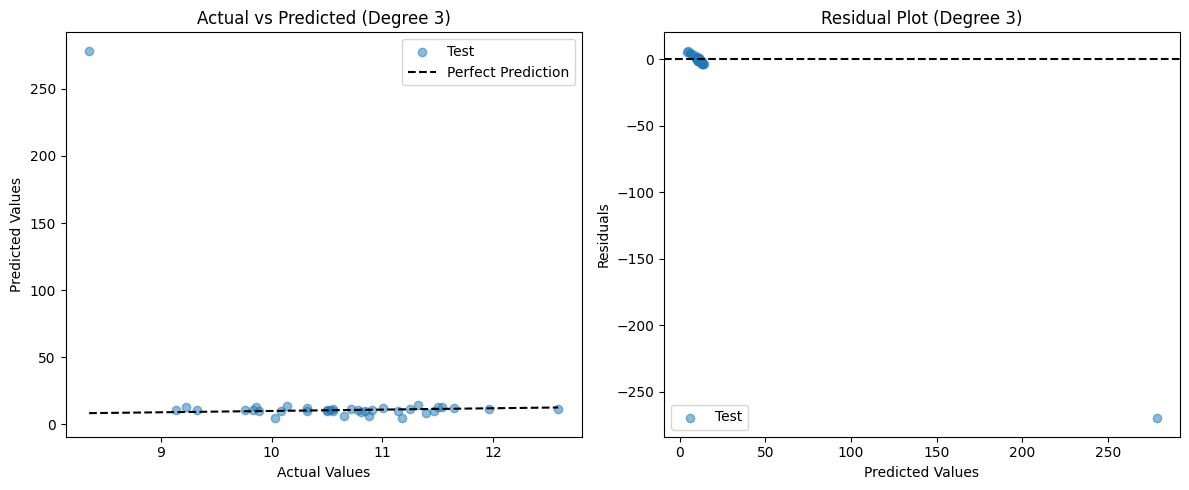

 Degree    Train R2  Validation R2      Test R2  Cross-Validation R2 Mean  Cross-Validation R2 Std  Train RMSE  Validation RMSE  Test RMSE
      1    0.225557       0.083876     0.172357                  0.164356                 0.049100    0.624798         0.697681   0.763571
      2    0.066979      -0.052453     0.127100                 -0.001440                 0.368614    0.685789         0.747793   0.784170
      3 -800.428793     -42.407744 -2804.816744               -497.159593               990.969806   20.099127         4.802457  44.458805

Model Performance for Different Polynomial Degrees:


In [130]:
# With your own data
df = garmin_activities_prep_uni_regr
degrees_to_test = [1, 2, 3]  # Specify the polynomial degrees you want to test
results = run_multivariate_analysis(df, target_column='gemiddeld_tempo_km/h', degrees=degrees_to_test)

# Print results as a table
print(results['results_table'].to_string(index=False))
print("\nModel Performance for Different Polynomial Degrees:")


In [127]:
def run_multivariate_analysis(df, target_column, degrees=[1], k=5, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Run complete multivariate regression analysis with polynomial feature expansion and k-fold cross-validation with bootstrapping.
    """
    # 1. Data Preparation
    df = df.dropna()
    X = df.select_dtypes(include=[np.number]).drop(columns=[target_column])
    y = df[target_column]
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    # 2. Split Data
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=(1 - train_size), random_state=42)
    val_test_ratio = test_size / (val_size + test_size)  # Adjust test split proportionally
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_test_ratio, random_state=42)
    
    results_list = []
    
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        X_test_poly = poly.transform(X_test)
        
        # Train Model with Cross-Validation and Bootstrapping
        model = LinearRegression()
        scores = cross_val_score(model, X_train_poly, y_train, cv=k, scoring='r2')
        
        # Bootstrap Sampling for Model Training
        X_train_boot, y_train_boot = resample(X_train_poly, y_train, random_state=42)
        model.fit(X_train_boot, y_train_boot)
        
        # Make Predictions
        y_train_pred = model.predict(X_train_poly)
        y_val_pred = model.predict(X_val_poly)
        y_test_pred = model.predict(X_test_poly)
        
        # Calculate Metrics
        results_list.append({
            'Degree': degree,
            'Train R2': r2_score(y_train, y_train_pred),
            'Validation R2': r2_score(y_val, y_val_pred),
            'Test R2': r2_score(y_test, y_test_pred),
            'Cross-Validation R2 Mean': np.mean(scores),
            'Cross-Validation R2 Std': np.std(scores),
            'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
        })
        
        # Visualization
        plt.figure(figsize=(12, 5))
        
        # Actual vs Predicted Plot
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_train_pred, alpha=0.5, label='Train')
        plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validation')
        plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test')
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (Degree {degree})')
        plt.legend()
        
        # Residual Plot
        plt.subplot(1, 2, 2)
        plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.5, label='Train')
        plt.scatter(y_val_pred, y_val - y_val_pred, alpha=0.5, label='Validation')
        plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, label='Test')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot (Degree {degree})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Convert results to DataFrame for tabular representation
    results_df = pd.DataFrame(results_list)
    
    return {
        'results_table': results_df,
        'scaler': scaler
    }
